In [1]:
%load_ext autoreload
%autoreload 2
import src.data_proc as data_proc

import numpy as np
import pandas as pd
import sys
import os
import gc
import random
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None
pd.options.display.float_format

from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor, Pool

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

In [2]:
%%time
# Load in 2016 properties data
prop = data_proc.load_properties_data("data/properties_2016.csv")
print("Number of properties: {}".format(len(prop)))
print("Number of property features: {}".format(len(prop.columns)-1))

# Load in 2016 training data (with logerror labels)
train_2016 = data_proc.load_training_data("data/train_2016_v2.csv")
print("Number of 2016 transaction records: {}".format(len(train_2016)))
print("\n", train_2016.head())

Number of properties: 2985217
Number of property features: 57
Number of 2016 transaction records: 90275

    parcelid  logerror transactiondate
0  11016594    0.0276      2016-01-01
1  14366692   -0.1684      2016-01-01
2  12098116   -0.0040      2016-01-01
3  12643413    0.0218      2016-01-02
4  14432541   -0.0050      2016-01-02
CPU times: user 17 s, sys: 3.57 s, total: 20.6 s
Wall time: 20.6 s


In [3]:
%%time
# Rename & retype the feature columns; also unify representations of missing values
data_proc.rename_columns(prop)
data_proc.retype_columns(prop)

CPU times: user 19.2 s, sys: 16.4 s, total: 35.7 s
Wall time: 35.6 s


In [4]:
# Join the training data with the property table
train_2016 = train_2016.merge(how='left', right=prop, on='parcelid')
train_2016.head(10)

,parcelid,logerror,transactiondate,cooling_id,architecture_style_id,basement_sqft,bathroom_cnt,bedroom_cnt,framing_id,quality_id,bathroom_cnt_calc,deck_id,floor1_sqft,finished_area_sqft_calc,finished_area_sqft,perimeter_area,total_area,floor1_sqft_unk,base_total_area,fips,fireplace_cnt,bathroom_full_cnt,garage_cnt,garage_sqft,spa_flag,heating_id,latitude,longitude,lot_sqft,pool_cnt,pool_total_size,pool_unk_1,pool_unk_2,pool_unk_3,county_landuse_code,landuse_type_id,zoning_description,census_1,city_id,county_id,neighborhood_id,region_zip,room_cnt,story_id,bathroom_small_cnt,construction_id,unit_cnt,patio_sqft,storage_sqft,year_built,story_cnt,fireplace_flag,tax_structure,tax_parcel,tax_year,tax_land,tax_property,tax_overdue_flag,tax_overdue_year,census_2
0,11016594,0.0276,2016-01-01,0,-1,NaN,2.0,3.0,-1,4.0,2.0,NaN,NaN,1684.0,1684.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,34280992.0,-118488536.0,7528.0,NaN,NaN,NaN,NaN,NaN,0100,230,LARS,60371068.0,12447.0,1815,31817.0,96370.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1959.0,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.879883,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,-1,-1,NaN,3.5,4.0,-1,NaN,3.5,NaN,NaN,2263.0,2263.0,NaN,NaN,NaN,NaN,22,NaN,3.0,2.0,468.0,NaN,-1,33668120.0,-117677552.0,3643.0,NaN,NaN,NaN,NaN,NaN,1,230,NaN,60590524.0,32380.0,0,NaN,96962.0,0.0,NaN,1.0,-1,NaN,NaN,NaN,2014.0,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.019531,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,0,-1,NaN,3.0,2.0,-1,4.0,3.0,NaN,NaN,2217.0,2217.0,NaN,NaN,NaN,NaN,0,NaN,3.0,NaN,NaN,NaN,1,34136312.0,-118175032.0,11423.0,NaN,NaN,NaN,NaN,NaN,0100,230,PSR6,60374640.0,47019.0,1815,275411.0,96293.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1940.0,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.480469,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,0,-1,NaN,2.0,2.0,-1,4.0,2.0,NaN,NaN,839.0,839.0,NaN,NaN,NaN,NaN,0,NaN,2.0,NaN,NaN,NaN,1,33755800.0,-118309000.0,70859.0,NaN,NaN,NaN,NaN,NaN,010C,235,LAR3,60372964.0,12447.0,1815,54300.0,96222.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1987.0,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.739990,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,-1,-1,NaN,2.5,4.0,-1,NaN,2.5,NaN,NaN,2283.0,2283.0,NaN,NaN,NaN,NaN,22,NaN,2.0,2.0,598.0,NaN,-1,33485644.0,-117700232.0,6000.0,1.0,NaN,NaN,NaN,1.0,122,230,NaN,60590424.0,17686.0,0,NaN,96961.0,8.0,NaN,1.0,-1,NaN,NaN,NaN,1981.0,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.959961,NaN,NaN,6.059042e+13
5,11509835,-0.2705,2016-01-02,0,-1,NaN,4.0,4.0,-1,1.0,4.0,NaN,NaN,3067.0,3067.0,NaN,NaN,NaN,NaN,0,NaN,4.0,NaN,NaN,NaN,1,33870088.0,-118402768.0,2708.0,NaN,NaN,NaN,NaN,NaN,0100,230,HBR3YY,60376212.0,29712.0,1815,NaN,96109.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1982.0,NaN,NaN,880650.0,2447951.0,2015.0,1567301.0,27126.570312,NaN,NaN,6.037621e+13
6,12286022,0.0440,2016-01-02,-1,-1,NaN,1.0,2.0,-1,7.0,1.0,NaN,NaN,1297.0,1297.0,NaN,NaN,NaN,NaN,0,NaN,1.0,NaN,NaN,NaN,6,33899476.0,-118212720.0,6677.0,NaN,NaN,NaN,NaN,NaN,0100,230,CORH*,60375416.0,24174.0,1815,NaN,96091.0,0.0,NaN,NaN,-1,1.0,NaN,NaN,1939.0,NaN,NaN,64549.0,111521.0,2015.0,46972.0,2304.969971,NaN,NaN,6.037542e+13
7,17177301,0.1638,2016-01-02,-1,-1,NaN,2.5,3.0,-1,NaN,2.5,NaN,853.0,1763.0,1763.0,NaN,NaN,853.0,NaN,74,1.0,2.0,2.0,0.0,NaN,-1,34207204.0,-119165592.0,NaN,NaN,NaN,NaN,NaN,NaN,1129,235,NaN,61110032.0,13150.0,775,NaN,97101.0,6.0,NaN,1.0,-1,NaN,NaN,NaN,1994.0,2.0,NaN,107000.0,306000.0,2015.0,199000.0,3745.500000,NaN,NaN,6.111003e+13
8,14739064,-0.0030,2016-01-02,-1,-1,NaN,1.0,2.0,-1,NaN,1.0,NaN,NaN,796.0,796.0,NaN,NaN,NaN,NaN,22,NaN,1.0,1.0,0.0,NaN,-1,33549600.0,-117678000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590424.0,25459.0,0,NaN,96987.0,0.0,NaN,NaN,-1,NaN,NaN,NaN,1984.0,NaN,NaN,66834.0,210064.0,2015.0,143230.0,2172.879883,NaN,NaN,6.059042e+13
9,14677559,0.0843,2016-01-03,-1,-1,NaN,2.0,2.0,-1,NaN,2.0,NaN,NaN,1260.0,1260.0,NaN,NaN,NaN,NaN,22,NaN,2.0,1.0,0.0,NaN,-1,33612700.0,-117742000.0,NaN,NaN,NaN,NaN,NaN,NaN,34,235,NaN,60590628.0,46098.0,0,NaN,96963.0,5.0,NaN,NaN,-1,NaN,NaN,NaN,1977.0,1.0,NaN,109977.0,190960

In [5]:
# Look at how complete (i.e. no missing value) each training set feature is
data_proc.print_complete_percentage(train_2016)

parcelid: 1.0
logerror: 1.0
transactiondate: 1.0
bathroom_cnt: 1.0
bedroom_cnt: 1.0
fips: 1.0
latitude: 1.0
longitude: 1.0
landuse_type_id: 1.0
census_1: 1.0
county_id: 1.0
room_cnt: 1.0
tax_year: 1.0
county_landuse_code: 0.9999889227360842
tax_parcel: 0.9999889227360842
tax_land: 0.9999889227360842
tax_property: 0.9999335364165052
region_zip: 0.9996122957629465
tax_structure: 0.9957906397119911
census_2: 0.9932982553309333
finished_area_sqft_calc: 0.9926779285516477
year_built: 0.9916255884796455
bathroom_cnt_calc: 0.9869066740515092
bathroom_full_cnt: 0.9869066740515092
city_id: 0.9800276931597895
finished_area_sqft: 0.948169482137912
lot_sqft: 0.8875657712545001
unit_cnt: 0.646391581279424
zoning_description: 0.6459484907227915
quality_id: 0.6354361672666852
heating_id: 0.6212129603987815
neighborhood_id: 0.39891442813625033
garage_cnt: 0.3316200498476876
garage_sqft: 0.3316200498476876
cooling_id: 0.318814732761008
story_cnt: 0.22785931874826917
pool_cnt: 0.19829410135696482
pool_u

count    90275.000000
mean         0.011457
std          0.161079
min         -4.605000
25%         -0.025300
50%          0.006000
75%          0.039200
max          4.737000
Name: logerror, dtype: float64


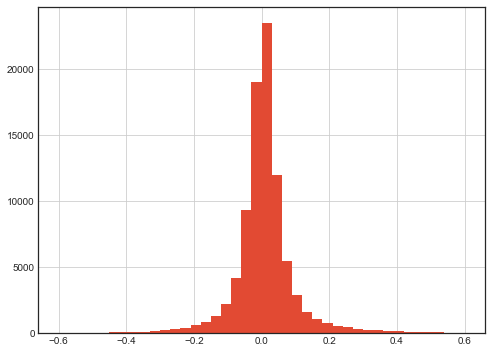

In [6]:
# Look at the distribution of the target variable (log-error)
print(train_2016['logerror'].describe())
train_2016.loc[abs(train_2016['logerror']) < 0.6, 'logerror'].hist(bins=40)

In [7]:
# Looks like there are some outliers in the training data (very large logerror)
# abs(logerror) > 0.6 seems abnormal, should probably remove them from the training set
threshold = 0.6
print("{} training examples in total".format(len(train_2016)))
print("{} with abs(logerror) > {}".format((abs(train_2016['logerror']) > threshold).sum(), threshold))

train_2016 = train_2016[abs(train_2016.logerror) <= threshold]

90275 training examples in total
951 with abs(logerror) > 0.6


In [8]:
# Let's see if there are any feature value outliers -> looks like things are mostly fine, no need to process
prop.describe().loc[['min', 'max', 'mean']].T

,min,max,mean
parcelid,1.071172e+07,1.696019e+08,1.332586e+07
basement_sqft,2.000000e+01,8.516000e+03,6.468833e+02
bathroom_cnt,0.000000e+00,2.000000e+01,2.209143e+00
bedroom_cnt,0.000000e+00,2.000000e+01,3.088949e+00
quality_id,1.000000e+00,1.200000e+01,5.784787e+00
bathroom_cnt_calc,1.000000e+00,2.000000e+01,2.299263e+00
deck_id,6.600000e+01,6.600000e+01,6.600000e+01
floor1_sqft,3.000000e+00,3.130300e+04,1.380660e+03
finished_area_sqft_calc,1.000000e+00,9.525760e+05,1.826764e+03
finished_area_sqft,1.000000e+00,2.903450e+05,1.759635e+03


In [9]:
# Analyze time dependency!
datetime = pd.to_datetime(train_2016.transactiondate).dt
train_2016['month'] = datetime.month
train_2016['quarter'] = datetime.quarter
print(train_2016.groupby('month')['month', 'logerror'].median())
print(train_2016.groupby('quarter')['quarter', 'logerror'].median())

       month  logerror
month                 
1          1    0.0090
2          2    0.0080
3          3    0.0010
4          4    0.0030
5          5    0.0030
6          6    0.0040
7          7    0.0050
8          8    0.0050
9          9    0.0100
10        10    0.0100
11        11    0.0119
12        12    0.0100
         quarter  logerror
quarter                   
1              1    0.0050
2              2    0.0030
3              3    0.0070
4              4    0.0109


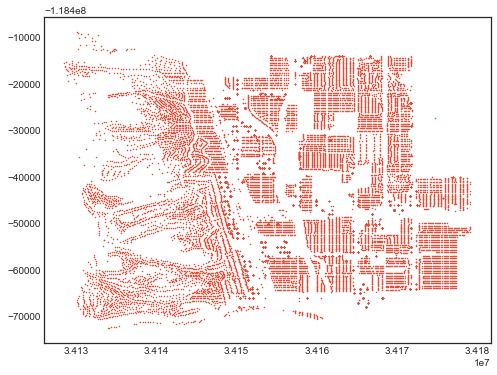

In [10]:
# Let's see how a 'neighborhood' is defined
# Maybe we can extract some neighborhood-based aggregate features
df = prop[prop.neighborhood_id == 27080]
plt.scatter(df.latitude, df.longitude, s=1)